In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

In [2]:
import math
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
import operator

import config
from config import load_users_dataframe
from config import load_networkx_all
from config import load_networkx_friends
from config import load_networkx_potential

# Plotting
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Networkx
from networkx.drawing.nx_agraph import graphviz_layout
import dzcnapy_plotlib as dzcnapy


sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

# plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

project_name = config.settings['data']['eventname']
timeframe = config.settings['timeframe']
save_to_file = config.settings['save_to_file'] == 'True'
window = 30
unique_users = load_users_dataframe()
network_all = load_networkx_all()
network_friends = load_networkx_friends()
network_potential = load_networkx_potential()

{'calculate': {'analysis': True,
               'friends': False,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'cwd': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy',
          'networkx': {'all': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',
                       'potential': '/Users/lzhou/git/github/uclresearchanalysis/data/givenchy/pickle/networkx_potential.dat'},
          'newcrawl': '/Users/lzhou/git/github/uclresearchanalysis/other/newcrawl.dat',
          'pickle': {'friends': '/Users/lzhou/git/github/uclresea

/Users/lzhou/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
unique_users.head()

,user,user_id,time_lapsed,followers_count,friends_count,mention_and_reply,source_candidates,source_index,seed_index,generation,time_since_seed
0,davelackie,100766356,0.00,143119,4643,[],"[3, 5, 6, 7, 10, 11, 14, 15, 19, 20, 24, 74, 8...",None,0,0,0
1,alexanderskhan,3186545203,0.15,753,3428,[0],[0],0,0,1,0.15
2,consiglierela,4134992843,0.23,2161,396,[0],"[0, 12, 21, 32, 48, 748, 819, 972, 2358, 2778,...",0,0,1,0.23
3,ImpactPrincess,1955472014,0.63,242,642,[0],"[0, 115, 577]",0,0,1,0.63
4,Damek0Masca,406301175,1.13,116,239,[],[],None,4,0,0


In [4]:
inDegreeView = network_friends.in_degree()

In [5]:
outDegreeView = network_friends.out_degree()

In [6]:
unique_users.time_lapsed = np.ceil(unique_users.time_lapsed/30)

In [7]:
unique_users.head()

,user,user_id,time_lapsed,followers_count,friends_count,mention_and_reply,source_candidates,source_index,seed_index,generation,time_since_seed
0,davelackie,100766356,0.0,143119,4643,[],"[3, 5, 6, 7, 10, 11, 14, 15, 19, 20, 24, 74, 8...",None,0,0,0
1,alexanderskhan,3186545203,1.0,753,3428,[0],[0],0,0,1,0.15
2,consiglierela,4134992843,1.0,2161,396,[0],"[0, 12, 21, 32, 48, 748, 819, 972, 2358, 2778,...",0,0,1,0.23
3,ImpactPrincess,1955472014,1.0,242,642,[0],"[0, 115, 577]",0,0,1,0.63
4,Damek0Masca,406301175,1.0,116,239,[],[],None,4,0,0


In [35]:
from tqdm import tqdm

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

parametersVector = ["tTotal", "kIn", 
                    "kOut0", "t0", 
                    "kOut-1", "t-1", 
                    "kOutMax", "kOutMin", "kOutAverage", "tAverage", "nNodes", "label"]

interval = 30

df = pd.DataFrame(columns=parametersVector)
with tqdm(total=len(list(unique_users.iterrows()))) as pbar: 
    for index, row in unique_users[0:2].iterrows():
        if row['source_index'] is not None:
            source_candidates = row['source_candidates']
            start_time = int(unique_users.iloc[source_candidates[0]].time_lapsed / interval)
            label = []
            tTotal = list(range(start_time, int(24*60/interval)))
            t0 = []
            t_1 = []
            kIn = []
            kOut0 = []
            kOut_1 = []
            kOutMax = []
            kOutMin = []
            kOutAverage = []
            nNodes = []
            tAverage = []

            for bar in range(start_time, 24*2):
                sources = [x for x in source_candidates if unique_users.iloc[x].time_lapsed <= bar]
                degreeOut = [outDegreeView[x] for x in sources]
                timeOut = [unique_users.iloc[x].time_lapsed for x in sources]
                label.append(int(bar >= row['time_lapsed']))
                t0.append(bar - start_time)
                t_1.append(bar - int(unique_users.iloc[sources[-1]].time_lapsed))
                kIn.append(inDegreeView[index])
                kOut0.append(outDegreeView[sources[0]])
                kOut_1.append(outDegreeView[sources[-1]])
                kOutMax.append(max(degreeOut))
                kOutMin.append(min(degreeOut))
                kOutAverage.append(mean(degreeOut))
                nNodes.append(len(sources))
                tAverage.append(mean(timeOut))
                
            df = df.append(pd.DataFrame({
                'label': label,
                'tTotal': tTotal,
                't0': t0,
                't-1': t_1,
                'kIn': kIn,
                'kOut0': kOut0,
                'kOut-1': kOut_1,
                'kOutMax': kOutMax,
                'kOutMin': kOutMin,
                'kOutAverage': kOutAverage,
                'nNodes': nNodes,
                'tAverage': tAverage
                }))
        pbar.update(1)

  0%|          | 2/5011 [00:00<01:10, 70.79it/s]


In [37]:
df

,kIn,kOut-1,kOut0,kOutAverage,kOutMax,kOutMin,label,nNodes,t-1,t0,tAverage,tTotal
0,1,183,183,183.0,183,183,0,1,0,0,0.0,0
1,1,183,183,183.0,183,183,1,1,1,1,0.0,1
2,1,183,183,183.0,183,183,1,1,2,2,0.0,2
3,1,183,183,183.0,183,183,1,1,3,3,0.0,3
4,1,183,183,183.0,183,183,1,1,4,4,0.0,4
5,1,183,183,183.0,183,183,1,1,5,5,0.0,5
6,1,183,183,183.0,183,183,1,1,6,6,0.0,6
7,1,183,183,183.0,183,183,1,1,7,7,0.0,7
8,1,183,183,183.0,183,183,1,1,8,8,0.0,8
9,1,183,183,183.0,183,183,1,1,9,9,0.0,9


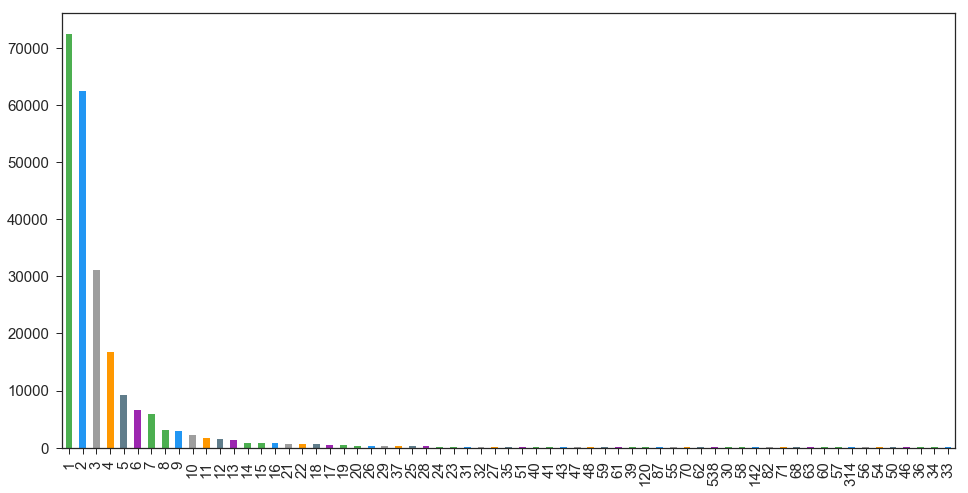

In [10]:
df.kIn.value_counts().plot(kind="bar", rot=90);

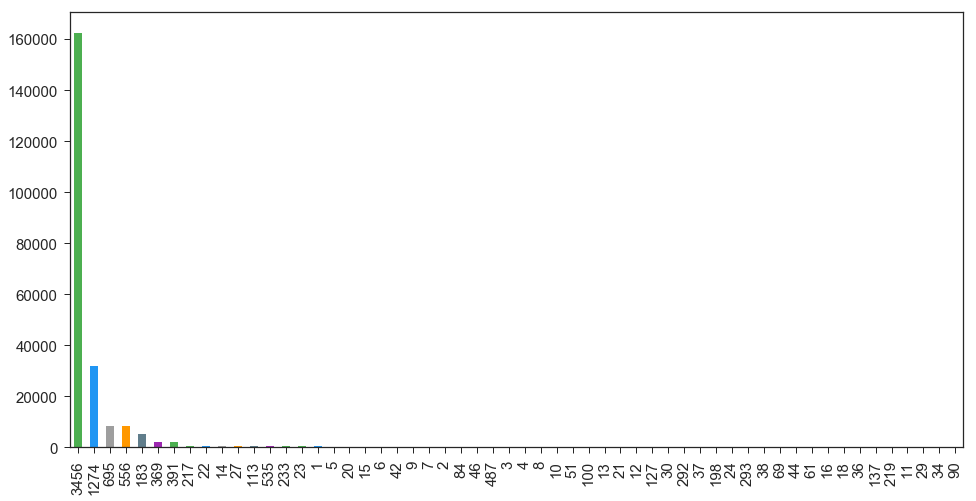

In [118]:
df.kOutMax.value_counts().plot(kind="bar", rot=90);

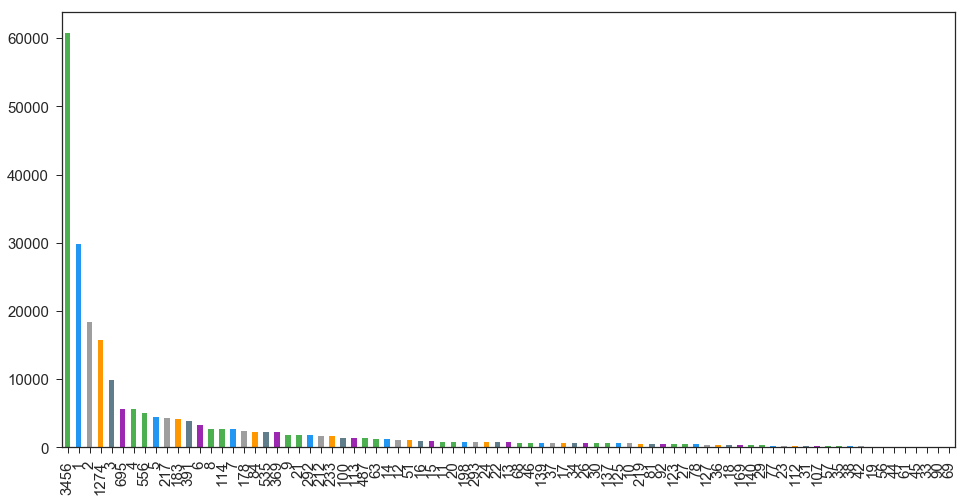

In [119]:
df.kOutMin.value_counts().plot(kind="bar", rot=90);

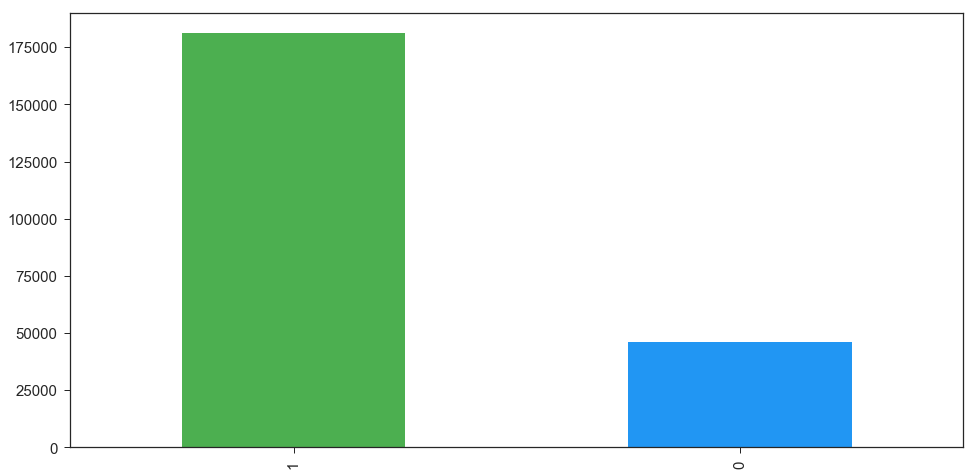

In [120]:
df.label.value_counts().plot(kind="bar", rot=90);

In [14]:
def encode(series): 
    return pd.get_dummies(series.astype(str))

In [15]:
parametersVector

['tTotal',
 'kIn',
 'kOut0',
 't0',
 'kOut-1',
 't-1',
 'kOutMax',
 'kOutMin',
 'kOutAverage',
 'tAverage',
 'nNodes',
 'label']

In [16]:
train_x = df.iloc[:,[0,1,2,3,4,5,7,8,9,10,11]]
train_y = encode(df.label)

In [17]:
def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

In [18]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

training_epochs = 200
display_step = 10
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

predictions = multilayer_perceptron(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [19]:
train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                keep_prob: 0.8
                            })
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 1863.206100589
Epoch: 0011 cost= 24.654412053
Epoch: 0021 cost= 0.975707925
Epoch: 0031 cost= 0.234983667
Epoch: 0041 cost= 0.165340220
Epoch: 0051 cost= 0.136092994
Epoch: 0061 cost= 0.122672840
Epoch: 0071 cost= 0.096180369
Epoch: 0081 cost= 0.090208523
Epoch: 0091 cost= 0.092633737
Epoch: 0101 cost= 0.081863473
Epoch: 0111 cost= 0.079508164
Epoch: 0121 cost= 0.088320346
Epoch: 0131 cost= 0.081889701
Epoch: 0141 cost= 0.085367732
Epoch: 0151 cost= 0.080274996
Epoch: 0161 cost= 0.087106082
Epoch: 0171 cost= 0.076450180
Epoch: 0181 cost= 0.075090901
Epoch: 0191 cost= 0.075001404
Optimization Finished!
Accuracy: 0.781705
